In [ ]:
# default_exp core

# core

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import functools
import math
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
from tensorflow.python.ops import nn_ops
from tensorflow import keras
from fastcore.nb_imports import *
from fastcore.test import *
from fastcore.foundation import *
import warnings

# Gabor Layer Math

$$G_\theta(x',y';\sigma,\gamma,\lambda,\psi):=e^{-\frac{(x'^2+\gamma^2y'^2)}{\sigma^2}}cos(\lambda x' + \psi)$$
$$x' = x cos\theta - y sin\theta$$
$$y' = x sin\theta + y cos\theta$$

In [ ]:
#export
class GaborLayer(keras.layers.Layer):
    def __init__(self, filters, kernel_size, orientations, learn_orientations=False,
                 use_bias=True, activation='relu', strides=(1, 1), 
                 padding='SAME', use_alphas=True, sigma_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.orientations = orientations
        self.learn_orientations = learn_orientations
        self.use_bias = use_bias
        self.strides = strides
        # can use strings as activation functions
        self.activation = keras.activations.get(activation)
        self.padding = padding
        self.rank = 2
        self.pi = tf.constant(math.pi, dtype=tf.float32)
        self.use_alphas = use_alphas
        self.sigma_regularizer = sigma_regularizer
        
        if self.learn_orientations:
            self.total_filters = self.filters
            if self.orientations > 0:
                warnings.warn('Orientations parameters is of no use.')
        else:
            self.total_filters = self.filters * self.orientations

In [ ]:
GT = GaborLayer(10, (10, 10), 0, True)
test_eq(GT.total_filters, 10)
GT = GaborLayer(10, (10, 10), 3, False)
test_eq(GT.total_filters, 30)

In [ ]:
#export
@patch
def create_xy_grid(self:GaborLayer):
    xmin, xmax = -1.0, 1.0
    ymin, ymax = -1.0, 1.0
    x_space = tf.linspace(xmin, xmax, self.kernel_size[0])
    y_space = tf.linspace(ymin, ymax, self.kernel_size[1])
    x, y = tf.meshgrid(y_space, x_space)
    
    return x, y

Test the outputs size of the meshgrid.

In [ ]:
kernel_size = (10, 10)
x, y = GaborLayer(filters=10, kernel_size=kernel_size, orientations=8).create_xy_grid()

test_eq(x.shape, kernel_size)
test_eq(y.shape, kernel_size)

kernel_size = (5, 10)
x, y = GaborLayer(filters=10, kernel_size=kernel_size, orientations=8).create_xy_grid()

test_eq(x.shape, kernel_size)
test_eq(y.shape, kernel_size)

In [ ]:
#export
@patch
def build(self:GaborLayer, batch_input_shape):
        self.input_channels = batch_input_shape[-1]
        
        self.gammas = self.add_weight(name='gammas', shape=[self.filters, 1, 1, 1, 1], 
                                            initializer='random_normal', trainable=True)
        self.psis = self.add_weight(name='psis', shape=[self.filters, 1, 1, 1, 1], 
                                   initializer='random_normal', trainable=True)
        self.sigmas = self.add_weight(name='sigmas', shape=[self.filters, 1, 1, 1, 1], 
                                      initializer='random_normal', trainable=True, 
                                      regularizer=self.sigma_regularizer)
        self.lambdas = self.add_weight(name='lambdas', shape=[self.filters, 1, 1, 1, 1], 
                                   initializer='random_normal', trainable=True)
        
        if self.use_alphas:
            self.alphas = self.add_weight(name='alphas', shape=[self.total_filters, 1, 1, 1], 
                                   initializer='random_normal', trainable=True)
        
        if self.use_bias:
            self.bias = self.add_weight(name='bias', shape=[self.total_filters],
                                         initializer='zeros')
            
        if self.learn_orientations:
            self.thetas = self.add_weight(name='thetas', shape=[self.filters, 1, 1, 1], 
                                          initializer='random_normal')
        else:
            thetas = (tf.range(0, self.orientations, dtype=tf.float32) * 2 * self.pi) / self.orientations
            thetas = tf.reshape(thetas, (self.orientations, 1 ,1, 1))
            self.thetas = tf.Variable(thetas, name='thetas', trainable=False)

        x, y = self.create_xy_grid()
        
        x = x[None, :, :, None]
        y = y[None, :, :, None]
        
        x = tf.repeat(x, repeats=self.input_channels, axis=-1)
        y = tf.repeat(y, repeats=self.input_channels, axis=-1)
        
        self.x = tf.Variable(x, name='x', trainable=False)
        self.y = tf.Variable(y, name='y', trainable=False)
        
        self._convolution_op = functools.partial(nn_ops.convolution_v2, strides=self.strides,
                                                padding=self.padding,
                                                name="Gabor_Convolution")
        self.kernel = self.create_kernel()

        self.built = True
        #super(GaborLayer, self).build(batch_input_shape)

In [ ]:
# export
@patch
def create_kernel(self:GaborLayer):
    sines = tf.sin(self.thetas)
    cosines = tf.cos(self.thetas)

    xprime = self.x * cosines - self.y * sines
    yprime = self.x * sines + self.y * cosines

    if self.learn_orientations:
        # Expanding in Filter direction
        xprime = xprime[:, None, :, :]
        yprime = yprime[:, None, :, :]
    else:
        # Expanding in Orientation direction
        xprime = xprime[None, :, :, :]
        yprime = yprime[None, :, :, :]
        
    ori_y_term = self.gammas ** 2 * yprime ** 2
    exponent_ori = (xprime ** 2 + ori_y_term) * self.sigmas ** 2
    gaussian_term_ori = tf.exp(-exponent_ori)
    cosine_term = tf.cos(xprime * self.lambdas + self.psis)

    ori_gb = gaussian_term_ori * cosine_term
    ori_gb = tf.reshape(ori_gb, 
                        (self.total_filters, 
                         *self.kernel_size, self.input_channels))

    if self.use_alphas:
        ori_gb = self.alphas * ori_gb
        
    kernel = ori_gb
    return kernel


In [ ]:
#export
@patch
def call(self:GaborLayer, X):
    
    self.kernel = self.create_kernel()
    kernel = tf.transpose(self.kernel, [1, 2, 3, 0])

    X = self._convolution_op(X, kernel)

    if self.use_bias:
        X = tf.nn.bias_add(X, self.bias)

    X = self.activation(X)
    return X


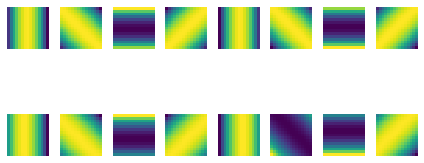

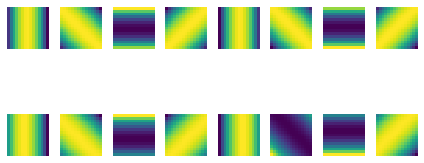

In [ ]:
GL = GaborLayer(filters=2, kernel_size=(15, 15), orientations=8, use_alphas=True)
GL.build([None, 28, 28, 2])


for jj in range(2):
    fig, axes = plt.subplots(2, 8)

    for n, ax in enumerate(axes.flatten()):
        ax.imshow(GL.kernel[n,:,:,jj])
        ax.axis('off')
    
    plt.tight_layout()

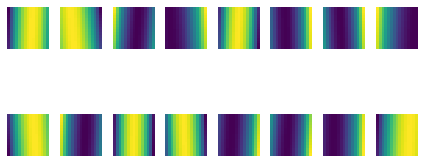

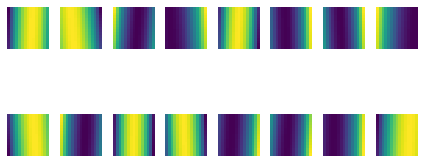

In [ ]:
GL = GaborLayer(filters=16, kernel_size=(15, 15), orientations=0, 
                use_alphas=True, learn_orientations=True)
GL.build([None, 28, 28, 2])


for jj in range(2):
    fig, axes = plt.subplots(2, 8)

    for n, ax in enumerate(axes.flatten()):
        ax.imshow(GL.kernel[n,:,:,jj])
        ax.axis('off')
    
    plt.tight_layout()

In [ ]:
#export
@patch
def get_config(self:GaborLayer):

    config = super(GaborLayer, self).get_config().copy()
    config.update({
        'filters': self.filters,
        'kernel_size': self.kernel_size,
        'orientations': self.orientations,
        'learn_orientations': self.learn_orientations,
        'use_bias': self.use_bias,
        'strides': self.strides,
        'activation' : self.activation,
        'padding': self.padding,
        'rank': self.rank,
        'pi': self.pi,
        'use_alphas': self.use_alphas,
        'kernel': self.kernel,
        'total_filters': self.total_filters
    })
    return config


In [ ]:
GL.get_config();

# Implementing Regularizer

In [ ]:
# export
class SigmaRegularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
        
    def __call__(self, weights):    
        return tf.reduce_sum(weights ** 2) * self.factor
    
    def get_config(self):
        return {'factor': self.factor}

In [ ]:
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
